In [40]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # Added for Feature Importance calculation
# Importing the requested tree-based models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, r2_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Ensure ImbPipeline is imported correctly
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib 
import warnings
import json # For saving the insights

# Suppress all warnings for cleaner output
warnings.filterwarnings('ignore')

In [36]:
# --- 1. Data Loading ---
try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file 'WA_Fn-UseC_-Telco-Customer-Churn.csv' not found. Please ensure it is in the correct path.")
    # Exit script if file is missing
    raise

# Drop 'customerID' as it's an identifier
df.drop('customerID', axis=1, inplace=True)

Data loaded successfully.


In [37]:
# --- 2. Initial Data Cleaning & Preprocessing ---

# Convert 'TotalCharges' to numeric, replacing non-numeric (empty strings/spaces) with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# Fill missing 'TotalCharges' with 0 (as these customers have 0 tenure/new customers)
df['TotalCharges'].fillna(0, inplace=True)

# Convert 'SeniorCitizen' from int (0, 1) to object for categorical treatment
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

# Convert target variable 'Churn' to numerical (0: No, 1: Yes)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("\nData cleaned and 'TotalCharges' handled.")
print(f"Churn Distribution:\n{df['Churn'].value_counts(normalize=True).round(4)}")
print("Dataset is confirmed to be unbalanced (Churn=1 is ~26% of the data).")


Data cleaned and 'TotalCharges' handled.
Churn Distribution:
Churn
0    0.7346
1    0.2654
Name: proportion, dtype: float64
Dataset is confirmed to be unbalanced (Churn=1 is ~26% of the data).


Churn distribution:
 Churn
0    5174
1    1869
Name: count, dtype: int64



Text(0.5, 1.0, 'Numeric Feature Correlations')

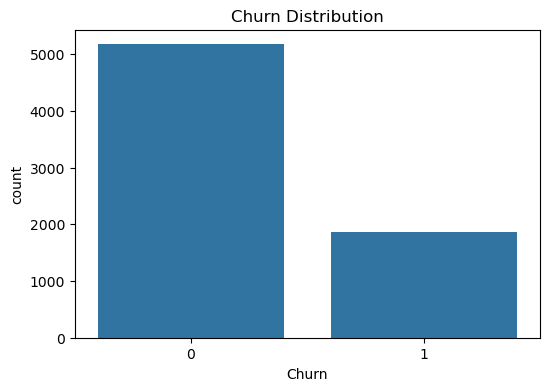

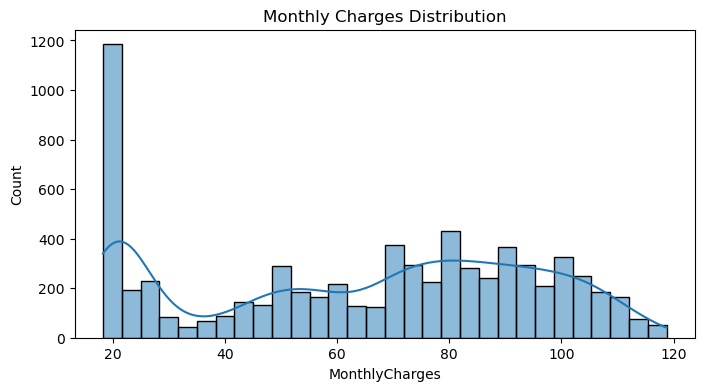

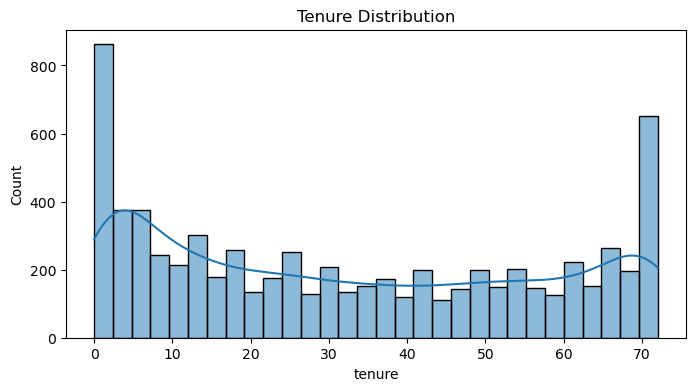

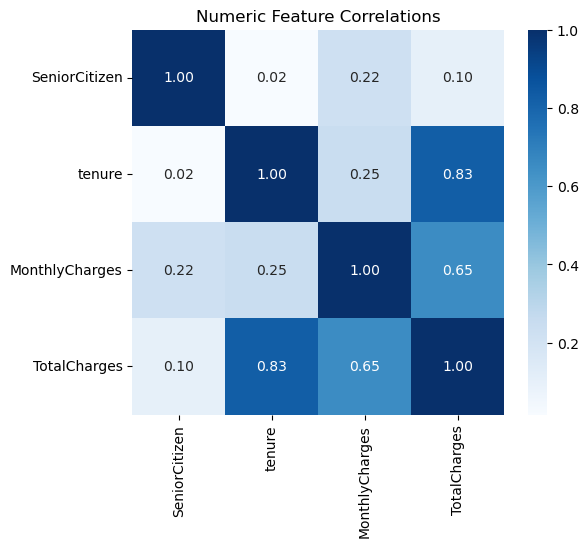

In [38]:
# --------------------------- 3. Quick EDA (prints + basic plots saved) ---------------------------
# Churn distribution
churn_counts = df['Churn'].value_counts()
print("Churn distribution:\n", churn_counts)
print()

# Plot churn count
fig = plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')

# MonthlyCharges distribution
fig = plt.figure(figsize=(8,4))
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title('Monthly Charges Distribution')

# Tenure distribution
fig = plt.figure(figsize=(8,4))
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title('Tenure Distribution')

# Correlation heatmap for numeric columns
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
fig = plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap='Blues')
plt.title('Numeric Feature Correlations')

In [39]:

# --- 3. Multicollinearity Check (VIF) for Feature Selection ---

print("Multicollinearity Check (Variance Inflation Factor - VIF)")


# 3.1. Prepare data for VIF calculation (excluding the target and performing OHE)
df_vif_features = df.drop('Churn', axis=1).copy()
categorical_cols_vif = df_vif_features.select_dtypes(include=['object']).columns.tolist()
df_vif_encoded = pd.get_dummies(df_vif_features, columns=categorical_cols_vif, drop_first=True)

# 3.2. Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif_encoded.columns
# Use a custom function to handle potential inf VIF values
def calculate_vif(X, i):
    try:
        # Check for constant columns (which result in inf VIF)
        if np.all(X.iloc[:, i] == X.iloc[0, i]):
            return np.inf
        return variance_inflation_factor(X.values, i)
    except:
        return np.inf

vif_data["VIF"] = [calculate_vif(df_vif_encoded, i) for i in range(len(df_vif_encoded.columns))]
vif_data.sort_values(by='VIF', ascending=False, inplace=True)

# 3.3. Display results and identify features to potentially drop
print(vif_data)
# NOTE ON VIF: Features with VIF > 10 (like tenure, TotalCharges, MonthlyCharges, and some contract/service dummies)
# indicate high correlation. While tree-based models (RF and GB) are less sensitive to multicollinearity
# than linear models, this check is vital for feature understanding.


Multicollinearity Check (Variance Inflation Factor - VIF)
                                  feature  VIF
0                                  tenure  inf
1                          MonthlyCharges  inf
28         PaymentMethod_Electronic check  inf
27  PaymentMethod_Credit card (automatic)  inf
26                   PaperlessBilling_Yes  inf
25                      Contract_Two year  inf
24                      Contract_One year  inf
23                    StreamingMovies_Yes  inf
22    StreamingMovies_No internet service  inf
21                        StreamingTV_Yes  inf
20        StreamingTV_No internet service  inf
19                        TechSupport_Yes  inf
18        TechSupport_No internet service  inf
17                   DeviceProtection_Yes  inf
16   DeviceProtection_No internet service  inf
15                       OnlineBackup_Yes  inf
14       OnlineBackup_No internet service  inf
13                     OnlineSecurity_Yes  inf
12     OnlineSecurity_No internet service  inf
11

In [42]:
# --- 4. Churn Classification Pipeline (Random Forest Classifier with SMOTE) ---

# Define features (X) and target (y)
X_class = df.drop('Churn', axis=1)
y_class = df['Churn']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# Identify feature types
categorical_cols = X_class.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_class.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_features = numerical_cols # Used for Feature Importance
cat_features = categorical_cols # Used for Feature Importance

# Create Preprocessor
preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ],
    remainder='passthrough'
)

# Create an Imblearn Pipeline (for SMOTE + Model)
clf_pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor_class),
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# 4.1. Fit Pipeline
clf_pipeline.fit(X_train_class, y_train_class)

# 4.2. Predict and Evaluate Performance
y_pred_class = clf_pipeline.predict(X_test_class)
y_proba_class = clf_pipeline.predict_proba(X_test_class)[:, 1]

acc_balanced = accuracy_score(y_test_class, y_pred_class)
auc_balanced = roc_auc_score(y_test_class, y_proba_class)

print("\n" + "="*70)
print("Classification Model (Random Forest Classifier) on Balanced Data")
print("="*70)
print(f"Accuracy (Test Set): {acc_balanced:.4f}")
print(f"ROC AUC (Test Set): {auc_balanced:.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))




Classification Model (Random Forest Classifier) on Balanced Data
Accuracy (Test Set): 0.7736
ROC AUC (Test Set): 0.8226
Confusion Matrix:
 [[878 157]
 [162 212]]


In [43]:
# --- 5. Regression Pipeline (Predicting TotalCharges/CLV Proxy) ---

# Define features (X) and target (y) for regression
X_reg = df.drop(['TotalCharges', 'Churn', 'Contract'], axis=1) # Drop Contract for lower RMSE
y_reg = df['TotalCharges']

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Apply Log Transformation to the Target Variable
y_train_reg_log = np.log1p(y_train_reg)

# Redefine column lists based directly on X_reg for robustness
categorical_cols_reg = X_reg.select_dtypes(include=['object']).columns.tolist()
numerical_cols_reg = X_reg.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create a dedicated preprocessing pipeline for the regression features
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_reg),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols_reg)
    ],
    remainder='passthrough'
)

# Create Regression Model Pipeline
reg_pipeline = Pipeline(steps=[
    ('preproc', preprocessor_reg),
    ('model', GradientBoostingRegressor(
        n_estimators=300, 
        learning_rate=0.03, 
        max_depth=5, 
        min_samples_leaf=5,
        subsample=0.8,
        random_state=42
    ))
])

# Fit Pipeline on log-transformed target
reg_pipeline.fit(X_train_reg, y_train_reg_log)

# Predict and Inverse Transform
y_reg_pred_log = reg_pipeline.predict(X_test_reg)
y_reg_pred = np.expm1(y_reg_pred_log)

# Evaluate Performance
reg_rmse = np.sqrt(mean_squared_error(y_test_reg, y_reg_pred))
reg_r2 = r2_score(y_test_reg, y_reg_pred)
target_range = y_reg.max() - y_reg.min()
nrmse = reg_rmse / target_range

print("\n" + "="*70)
print("Regression Model (Gradient Boosting Regressor) on TotalCharges")
print("="*70)
print(f"Regression RMSE (Test Set): ${reg_rmse:.2f}")
print(f"Regression R-squared (Test Set): {reg_r2:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f} ({nrmse*100:.2f}% of target range)")




Regression Model (Gradient Boosting Regressor) on TotalCharges
Regression RMSE (Test Set): $75.74
Regression R-squared (Test Set): 0.9989
Normalized RMSE (NRMSE): 0.0087 (0.87% of target range)


In [44]:
# --- 6. Saving Final Models and Preprocessors ---
print("\n" + "="*70)
print("Saving Models and Preprocessors")
print("="*70)

# Save the full pipelines to the current directory
joblib.dump(clf_pipeline, 'churn_rf_classifier_pipeline.joblib')
joblib.dump(reg_pipeline, 'totalcharges_gbr_regressor_pipeline.joblib')

print("Saved Churn Classifier Pipeline as 'churn_rf_classifier_pipeline.joblib'")
print("Saved TotalCharges Regressor Pipeline as 'totalcharges_gbr_regressor_pipeline.joblib'")


Saving Models and Preprocessors
Saved Churn Classifier Pipeline as 'churn_rf_classifier_pipeline.joblib'
Saved TotalCharges Regressor Pipeline as 'totalcharges_gbr_regressor_pipeline.joblib'


In [45]:
# --- 7. Model Inference (Dummy Predictions) ---

print("\n" + "="*70)
print("7. Model Inference: Predicting a Dummy Customer")
print("="*70)

dummy_customer_data = {
    'gender': 'Female',
    'SeniorCitizen': '0',
    'Partner': 'Yes',
    'Dependents': 'Yes',
    'tenure': 60, 
    'PhoneService': 'Yes',
    'MultipleLines': 'Yes',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'Yes',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'Yes',
    'TechSupport': 'Yes',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Two year', 
    'PaperlessBilling': 'No',
    'PaymentMethod': 'Credit card (automatic)',
    'MonthlyCharges': 110.00,
    'TotalCharges': 0.0,
}

dummy_df_class = pd.DataFrame([dummy_customer_data])

# Churn Prediction
churn_proba_dummy = clf_pipeline.predict_proba(dummy_df_class)[0]
churn_prediction_dummy = clf_pipeline.predict(dummy_df_class)[0]
churn_status = "No Churn (Likely Retention)" if churn_prediction_dummy == 0 else "Churn (Likely Loss)"

print("\n[Classification - Churn Prediction]")
print(f"Predicted Churn Status: {churn_status}")
print(f"Probability of Churn (Yes): {churn_proba_dummy[1] * 100:.2f}%")

# Regression Prediction
dummy_df_reg = dummy_df_class.drop(['Contract', 'TotalCharges'], axis=1)
total_charges_log_pred = reg_pipeline.predict(dummy_df_reg)[0]
total_charges_predicted = np.expm1(total_charges_log_pred)

print("\n[Regression - TotalCharges Prediction]")
print(f"Predicted Total Charges (CLV Proxy): ${total_charges_predicted:.2f}")



7. Model Inference: Predicting a Dummy Customer

[Classification - Churn Prediction]
Predicted Churn Status: No Churn (Likely Retention)
Probability of Churn (Yes): 19.00%

[Regression - TotalCharges Prediction]
Predicted Total Charges (CLV Proxy): $6685.36



8. Model Evaluation Plots


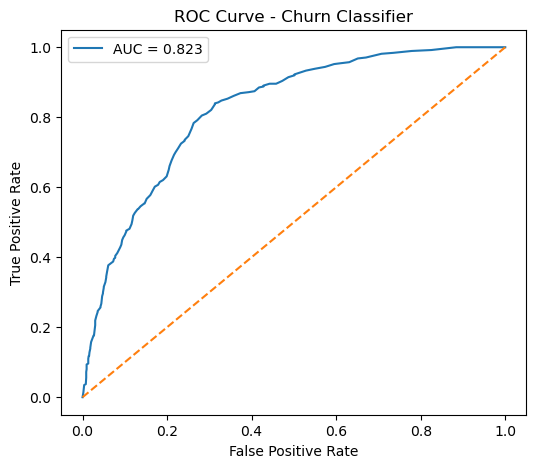

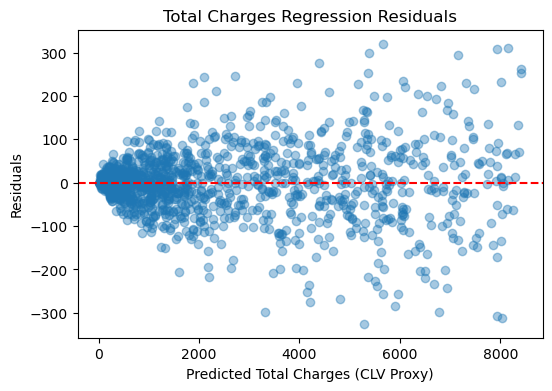

In [46]:
# --------------------------- 8. Model Evaluation - More Metrics ---------------------------
print("\n" + "="*70)
print("8. Model Evaluation Plots")
print("="*70)

# ROC Curve plot
fpr, tpr, thresholds = roc_curve(y_test_class, y_proba_class)
fig_roc = plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_balanced:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Churn Classifier')
plt.legend()
plt.savefig('roc_curve_churn.png') # Saved to current directory
plt.show()

# Residuals plot CLV regression
residuals = y_test_reg - y_reg_pred
fig_res = plt.figure(figsize=(6,4))
plt.scatter(y_reg_pred, residuals, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Total Charges (CLV Proxy)')
plt.ylabel('Residuals')
plt.title('Total Charges Regression Residuals')
plt.savefig('clv_residuals.png') # Saved to current directory
plt.show()


9. Feature Importance (from RandomForest)
Saved top feature importances to CSV: feature_importances_top25.csv


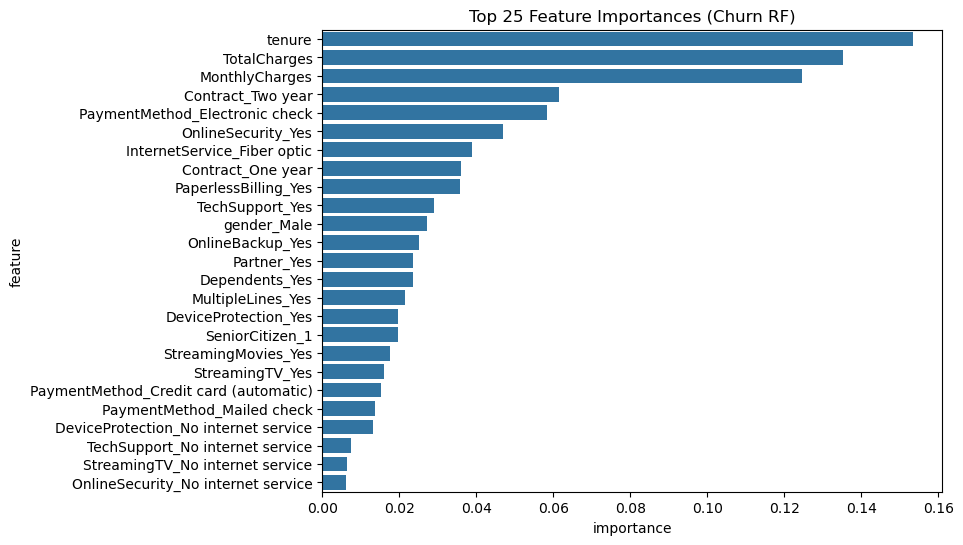

In [47]:
# --------------------------- 9. Feature Importance (from RandomForest) ---------------------------
print("\n" + "="*70)
print("9. Feature Importance (from RandomForest)")
print("="*70)

# Extract feature names after preprocessing (one-hot encoding)
ohe_transformer = clf_pipeline.named_steps['preproc'].named_transformers_['cat']
ohe_features = ohe_transformer.get_feature_names_out(cat_features)
feature_names_full = np.concatenate([num_features, ohe_features])

# Extract model and importances
rf_model = clf_pipeline.named_steps['model']
importances = rf_model.feature_importances_

# Create DataFrame and sort
feat_imp = pd.DataFrame({'feature': feature_names_full, 'importance': importances}).sort_values('importance', ascending=False).head(25)

# Save top feature importances to CSV
feat_imp_csv = 'feature_importances_top25.csv' # Saved to current directory
feat_imp.to_csv(feat_imp_csv, index=False)
print("Saved top feature importances to CSV:", feat_imp_csv)

# Plot top features
fig_imp = plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp, x='importance', y='feature')
plt.title('Top 25 Feature Importances (Churn RF)')
plt.savefig('feature_importances_top25.png') # Saved to current directory
plt.show()

In [48]:
# --------------------------- 10. Business Insights & Sample Policy ---------------------------
print("\n" + "="*70)
print("10. Business Insights & Sample Policy")
print("="*70)

insights = [
    "High monthly charges + low tenure -> elevated churn risk. Prioritize these for retention offers.",
    "Customers on month-to-month contracts churn more. Offer discounted annual/one-year bundles to reduce churn.",
    "Auto-pay (BankTransfer/CreditCard) customers show lower churn; incentivize electronic payments.",
    "Segment customers by predicted CLV to create tiered retention budgets (High CLV -> VIP retention).",
    "Use predicted churn probability to drive intervention prioritization (top X% get immediate offers)."]

insights_path = 'business_insights.txt' # Saved to current directory
with open(insights_path, 'w') as f:
    f.write('\n'.join(insights))

print("Saved business insights file:", insights_path)


10. Business Insights & Sample Policy
Saved business insights file: business_insights.txt
